In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('./Tesla stock prediction/Data/TSLA.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-08-16,45.098000,45.438000,44.681999,44.722000,44.722000,11335500
1,2016-08-17,44.866001,44.966000,44.560001,44.647999,44.647999,8935500
2,2016-08-18,44.764000,45.132000,44.458000,44.702000,44.702000,8572500
3,2016-08-19,44.708000,45.034000,44.506001,45.000000,45.000000,8297500
4,2016-08-22,44.834000,45.021999,44.535999,44.585999,44.585999,10327500


In [3]:
data['Date'].nunique()

1258

In [4]:
data.isna().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [5]:
data['Date'] = pd.to_datetime(data['Date'])
data.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

### Part 1 : Univariate example
#### I.e. [previous close prices] -> next_close_price

In [6]:
univariate = data[['Date', 'Close']].sort_values(by=['Date'], ascending=True)
plt.plot(univariate['Date'], univariate['Close'])
plt.title('TESLA stock prices')

,Date,Close
0,2016-08-16,44.722000
1,2016-08-17,44.647999
2,2016-08-18,44.702000
3,2016-08-19,45.000000
4,2016-08-22,44.585999


### Check for stationarity: the statistical properties of a time series (or rather the process generating it) do not change over time
#### Here we use the ADF test:
#### * Calculate test statistics and p-value
#### * If p-value > .05, fail to reject the null Hypothesis, i.e. data is not stationary

In [8]:
adfuller(univariate['Close'])

(0.32732560456343895,
 0.9785640149119201,
 21,
 1236,
 {'1%': -3.435651725648415,
  '5%': -2.863881223119536,
  '10%': -2.568016498910778},
 9440.827811903462)

#### We can see the p-value (0.98) is > 0.05, i.e. the data is not stationary, so we take the difference df.diff() and test for stationarity again

In [31]:
scaler = StandardScaler()
scaler = scaler.fit(univariate['Close'].values.reshape((-1,1)))
univariate['Close_diff'] = scaler.transform(univariate['Close'].values.reshape((-1,1)))
#univariate['Close'].diff()
adfuller(univariate['Close_diff'].fillna(0))

(0.32732560456038345,
 0.9785640149117875,
 21,
 1236,
 {'1%': -3.435651725648415,
  '5%': -2.863881223119536,
  '10%': -2.568016498910778},
 -3957.6754531398474)

### Now we define a function to create sequences of stock prices to predict the following stock price. We will use a timestep of 7, i.e. 7 days previous stock prices to predict the 8th days stock price
#### and rehape into (samples, timestep, variables) required by LSTM

In [32]:
def generate_univariate_sequences(data, time_step=7):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step)]   
        X.append(a)
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

In [33]:
time_step = 7

if variate == 'uni':
    n_features = 1
    X, y = generate_univariate_sequences(univariate['Close_diff'].fillna(0).values, time_step = time_step)
    X = X.reshape((-1, time_step, n_features))
elif variate == 'multi':
    n_features = 
X.shape, y.shape

((1250, 7, 1), (1250,))

#### Now we create train and test splits for our data 

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1000, 7, 1), (250, 7, 1), (1000,), (250,))

#### Let's create an LSTM model and fit it to our data

In [35]:
batch_size = 100
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model = models.Sequential()
model.add(layers.LSTM(50, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(layers.LSTM(25, return_sequences=False))
model.add(tf.keras.layers.BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 7, 50)             10400     
                                                                 
 lstm_5 (LSTM)               (None, 25)                7600      
                                                                 
 batch_normalization_2 (Batc  (None, 25)               100       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 25)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,126
Trainable params: 18,076
Non-trainable params: 50
_________________________________________________

In [37]:
history = model.fit(X_train, y_train, epochs=100, 
                    batch_size=batch_size, 
                    validation_split=0.2,
                    verbose=1,
                    shuffle=False)

Epoch 1/100
8/8 [==============================] - 2s 81ms/step - loss: 0.9422 - val_loss: 0.8672
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.5716 - val_loss: 0.9509
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.6136 - val_loss: 0.9318
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.3960 - val_loss: 0.9164
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.3382 - val_loss: 0.9676
Epoch 6/100
8/8 [==============================] - 0s 9ms/step - loss: 0.2439 - val_loss: 0.9678
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1770 - val_loss: 0.9836
Epoch 8/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1492 - val_loss: 0.9827
Epoch 9/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1178 - val_loss: 0.9978
Epoch 10/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0955 - val_loss: 1.0094
Epoch 11/100
8/8 [=======

8/8 [==============================] - 0s 9ms/step - loss: 0.0295 - val_loss: 0.1066
Epoch 85/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0273 - val_loss: 0.1201
Epoch 86/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0270 - val_loss: 0.1187
Epoch 87/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0290 - val_loss: 0.1083
Epoch 88/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0273 - val_loss: 0.0910
Epoch 89/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0284 - val_loss: 0.0926
Epoch 90/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0248 - val_loss: 0.0785
Epoch 91/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0261 - val_loss: 0.0704
Epoch 92/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0266 - val_loss: 0.0625
Epoch 93/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0247 - val_loss: 0.0695
Epoch 94/100
8/8 [===============

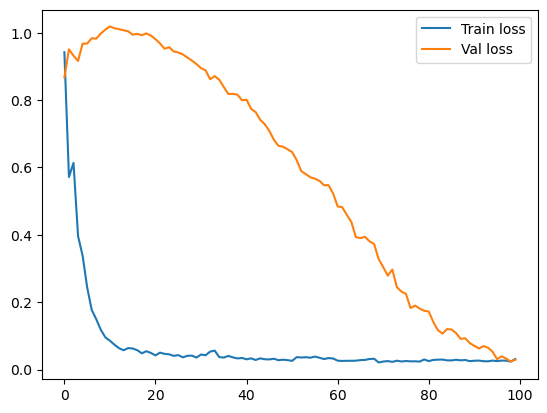

In [38]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.legend(['Train loss', 'Val loss'])

13/13 [==============================] - 0s 3ms/step


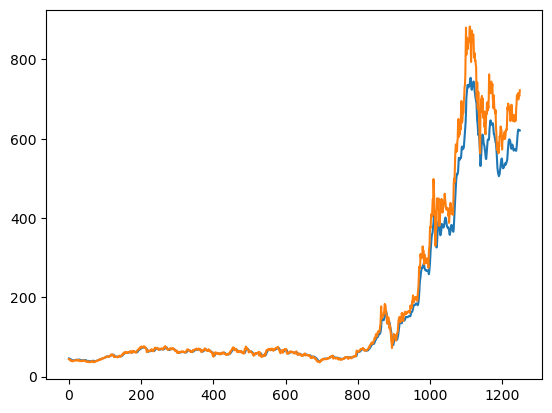

In [46]:
all_predictions = model.predict(X, batch_size=batch_size)
plt.plot(scaler.inverse_transform(all_predictions.reshape((-1,1))))
plt.plot(scaler.inverse_transform(y.reshape((-1,1))))